# Find me an asteroid

In this notebook we will show you how a machine may find asteroids in astronomical images.  Although this task is normally reserved to trained eyes, advances in computing allows us to perform the "dirty" tasks in the process with the help of algorithms.  

## Step 0: Before starting

We will need to load several external tools, our own routines and more importantly load the package fonfiguration *aisteroid.cfg*.  Be sure that you set the variables in this file.

In [1]:
from aisteroid import *
%matplotlib nbagg

Configuration:
{ 'AST_DIR': '/home/astrometry/astrometry/',
  'CFG': 'example',
  'HOME_DIR': '/home/jzuluaga/Astrometry/AIsteroid',
  'OVERWRITE': 0,
  'PHOTOPLOT': 1,
  'RADIUS': 3,
  'SET': 'example',
  'SEX_DIR': '/home/astrometry/sextractor/',
  'SUMMARY': 1,
  'TEAM': 'NEA',
  'TEAM_COUNTRY': 'Colombia',
  'TEAM_MEMBERS': 'J.Ospina, L. Piedraita, I.Moreno, S.Lopez, J. Zuluaga'}


---

## Step 1: The observation set

Choose the observation set you want to analyse

In [79]:
print("Available datasets:")
out=System("for i in $(ls "+CONF.SETS_DIR+"*.zip);do echo -n $(basename $i |cut -f 1 -d'.');echo -n ', ';done")

Available datasets:
example, ps1-20170913_1_set140, ps1-20170913_1_set141, ps1-20170913_1_set142, ps1-20170913_1_set143, ps1-20170913_4_set020, ps1-20170913_4_set021, ps1-20170914_11_set176, ps1-20170914_11_set177, ps1-20170914_11_set178, ps1-20170914_11_set179, ps1-20170914_11_set180, ps1-20170914_11_set181, ps1-20170914_11_set182, ps1-20170914_11_set183, ps1-20170914_4_set096, ps1-20170914_4_set104, ps1-20170914_4_set105, ps1-20170914_4_set106, ps1-20170914_4_set107, ps1-20170914_4_set108, ps1-20170914_4_set109, ps1-20170914_4_set110, ps1-20170915_4_set045, ps1-20170915_4_set046, ps1-20170915_4_set047, ps1-20170915_4_set048, ps1-20170915_4_set049, ps1-20170915_4_set050, ps1-20170915_4_set051,


In [80]:
#CONF.SET="example"
CONF.SET="ps1-20170914_4_set096"

In [179]:
#Output directory                                                                                                                                                                    
OUT_DIR=CONF.SCR_DIR+CONF.SET+"/"

#File to pickle analysis results                                                                                                                                                     
AIA=OUT_DIR+"analysis.aia"

#Observatory configuration file                                                                                                                                                      
CFG=[line.rstrip('\n') for line in open(CONF.SETS_DIR+CONF.CFG+".cfg")]

#Basic information about the observatory
MPCCODE=Config(CFG,"MPCCode")
OBSERVER=Config(CFG,"Observer")
TELESCOPE=Config(CFG,"Telescope")[0]

---

## Step 2: Unpack and read images

It is assumed that the observations set is packed as a *zip* file and contains the images in FITS format, sorted in alphabetical order

In [82]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#UNPACK THE IMAGE SET
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
setfile=CONF.SETS_DIR+CONF.SET+".zip"
if not os.path.isfile(setfile):
    error("No set file '%s'"%setfile)
out=System("rm -rf "+OUT_DIR)
out=System("mkdir -p "+OUT_DIR)
out=System("cp "+CONF.INPUT_DIR+"template/* "+OUT_DIR)
out=System("unzip -j -o -d "+OUT_DIR+" "+setfile)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#READ THE IMAGES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
images=[]
print("Reading images")
for image in sorted(glob.glob(OUT_DIR+"*.fits")):
    print("\tReading image "+image)
    hdul=fits.open(image)
    im=dict()
    im["file"]=image.split("/")[-1].replace(".fits","")
    im["header"]=hdul[0].header
    im["data"]=hdul[0].data
    im["obstime"]=hdul[0].header["DATE-OBS"]
    im["unixtime"]=date2unix(im["obstime"])
    images+=[im]
    hdul.close()
    f=open(OUT_DIR+"%s.head"%im["file"],"w")
    f.write(im["header"].tostring("\n"))
    f.close()
    nimgs=len(images)
if not len(images):
    print("No images provided.")
print("\tDone.")

Archive:  data/sets/ps1-20170914_4_set096.zip
  inflating: scratch/ps1-20170914_4_set096/o8010g0344o.1300829.ch.1992525.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0362o.1300847.ch.1992543.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0380o.1300865.ch.1992561.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0398o.1300883.ch.1992579.XY36.p00.fits
Reading images
	Reading image scratch/ps1-20170914_4_set096/o8010g0344o.1300829.ch.1992525.XY36.p00.fits
	Reading image scratch/ps1-20170914_4_set096/o8010g0362o.1300847.ch.1992543.XY36.p00.fits
	Reading image scratch/ps1-20170914_4_set096/o8010g0380o.1300865.ch.1992561.XY36.p00.fits
	Reading image scratch/ps1-20170914_4_set096/o8010g0398o.1300883.ch.1992579.XY36.p00.fits
	Done.


	Not annotated ('scratch/ps1-20170914_4_set096//ps1-20170914_4_set096.gif')


<IPython.core.display.Javascript object>


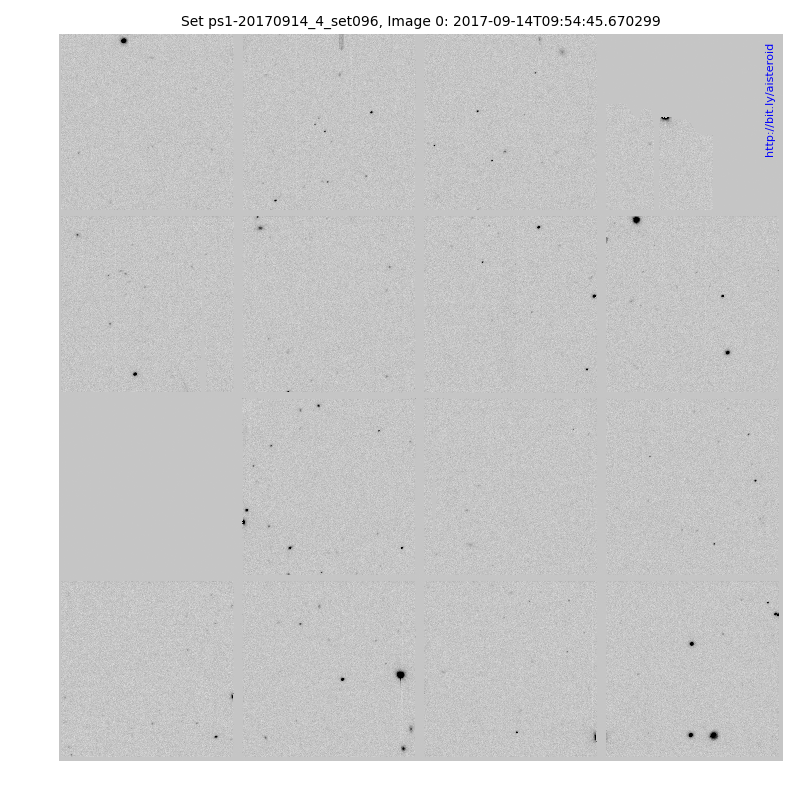

In [83]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#ANIMATION
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
animfile="%s/%s.gif"%(OUT_DIR,CONF.SET)
print("\tNot annotated ('%s')"%animfile)

#Figure
fig=plt.figure(figsize=(8,8))

#Show first image
imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
im=plt.imshow(images[0]["data"],animated=True,**imgargs)

#Title
tm=plt.title("Set %s, Image 0: "%CONF.SET+images[0]["obstime"],fontsize=10)

#Water mark
waterMark(fig.gca())

#Basic decoration
plt.axis("off")
fig.tight_layout()

#Update figure
def updatefig(i):
    #Select image
    iimg=i%nimgs
    im.set_array(images[iimg]["data"])
    tm.set_text("Set %s, Image %d: "%(CONF.SET,iimg)+images[iimg]["obstime"])
    return im,

#Create animation
ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                            interval=1000,repeat_delay=1000,
                            repeat=True,blit=True)

#Save animation
out=System("rm -rf %s/blink*"%OUT_DIR)
ani.save(OUT_DIR+'blink.html')
time.sleep(1)
out=System("convert -delay 100 $(find %s -name 'blink*.png' -o -name 'frame*.png' |grep -v '04' |sort) %s"%(OUT_DIR,animfile))
out=System("rm -rf blink*")

---

## Step 3: Telescope and CCD Properties

Some procedures need to know some of the properties of the equipment used to get the images.

In [84]:
print("Telescope & CCD Properties:")
FOCAL=Config(CFG,"FocalLength") #mm
PW=Config(CFG,"PixelWide") #mm
PH=Config(CFG,"PixelHigh") #mm
SIZEX=images[0]["header"]["NAXIS1"]
SIZEY=images[0]["header"]["NAXIS2"]
PWD=np.arctan(PW/FOCAL)*RAD
PHD=np.arctan(PW/FOCAL)*RAD
PXSIZE=(PWD+PHD)/2
print("\tFocal lenght (mm) :",FOCAL)
print("\tPixel size (x mm,y mm) :",PW,PH)
print("\tImage size (x px,y px) :",SIZEX,SIZEY)
print("\tPixel size (arcsec):",PXSIZE/ARCSEC)
print("\tCamera field (x deg,y deg) :",SIZEX*PWD,SIZEY*PHD)

Telescope & CCD Properties:
	Focal lenght (mm) : 8070.0
	Pixel size (x mm,y mm) : 0.01 0.01
	Image size (x px,y px) : 2423 2434
	Pixel size (arcsec): 0.255594555449
	Camera field (x deg,y deg) : 0.172029335514 0.172810318878


---

## Step 4: Extract sources

Once you have the images you may attempt at extracting the *sources*, ie. anything in the image that *resembles* a stellar object.  We perform this task using a third party application, [SEXtractor](https://www.astromatic.net/software/sextractor).

In [109]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#EXTRACTING SOURCES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("SEXtracting sources")
for i,image in enumerate(images):
    file=image["file"]
    header=image["header"]
    #SEX COMMAND
    print("\tRunning SEXtractor over %s..."%file)
    opts=""
    opts+=" "+"-c asteroid.sex"
    cmd=CONF.SEX_DIR+"bin/sex "+opts+" "+file+".fits"
    sys="cd "+OUT_DIR+";"+cmd
    out=System(sys)
    if out[-1][0]!=0:
        print("\t\tError processing image")
        print(out[-1][1])
    else:
        print("\t\tExtraction successful")
        #STORE RESULTS
        image["sex_output"]=out[-1][1]
        System("cd "+OUT_DIR+";cp asteroid.cat %s.cat"%file,False)
        hdul=fits.open(OUT_DIR+"%s.cat"%file)
        image["sourcexxy_header"]=hdul[1].header
        image["sourcexxy"]=hdul[1].data
        hdul.close()
        print("\t\t%d sources saved."%len(image["sourcexxy"]))
print("\tDone.")

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#COMPILING SOURCES INFORMATION
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Compiling all sources...")
allsources=pd.DataFrame()
for i,image in enumerate(images):
    srcxys=pd.DataFrame(image["sourcexxy"])
    alls=pd.concat([srcxys],axis=1)

    #Aligned coordinates
    alls["X_ALIGN"]=0.0
    alls["Y_ALIGN"]=0.0
    
    #Astrometry
    alls["RA"]=0.0
    alls["DEC"]=0.0
    alls["ERR_RA"]=0.0
    alls["ERR_DEC"]=0.0
        
    #Alignment attributes
    alls["IMG"]=i #In which image is this source
    alls["STAR"]=0 #Is this a star?
    alls["ALIGSET"]=0 #Alignment set

    #Detection attributes
    alls["OBJ"]=0 #To which object it belongs (detection procedure)
    alls["NIMG"]=1 #In how many images is the object present (detection procedure)
    alls["MOBJ"]=0 #To which moving object it belongs (detection procedure)

    #Photometric attributes
    alls["MAG_ASTRO"]=0.0
    alls["ERR_MAG_ASTRO"]=0.0
    
    allsources=allsources.append(alls)

allsources.sort_values(by="MAG_BEST",ascending=True,inplace=True)
allsources.reset_index(inplace=True)

for i,image in enumerate(images):
    image["xy"]=allsources[allsources.IMG==i][["X_IMAGE","Y_IMAGE"]].values

SEXtracting sources
	Running SEXtractor over o8010g0344o.1300829.ch.1992525.XY36.p00...
		Extraction successful
		374 sources saved.
	Running SEXtractor over o8010g0362o.1300847.ch.1992543.XY36.p00...
		Extraction successful
		429 sources saved.
	Running SEXtractor over o8010g0380o.1300865.ch.1992561.XY36.p00...
		Extraction successful
		420 sources saved.
	Running SEXtractor over o8010g0398o.1300883.ch.1992579.XY36.p00...
		Extraction successful
		411 sources saved.
	Done.
Compiling all sources...


<IPython.core.display.Javascript object>


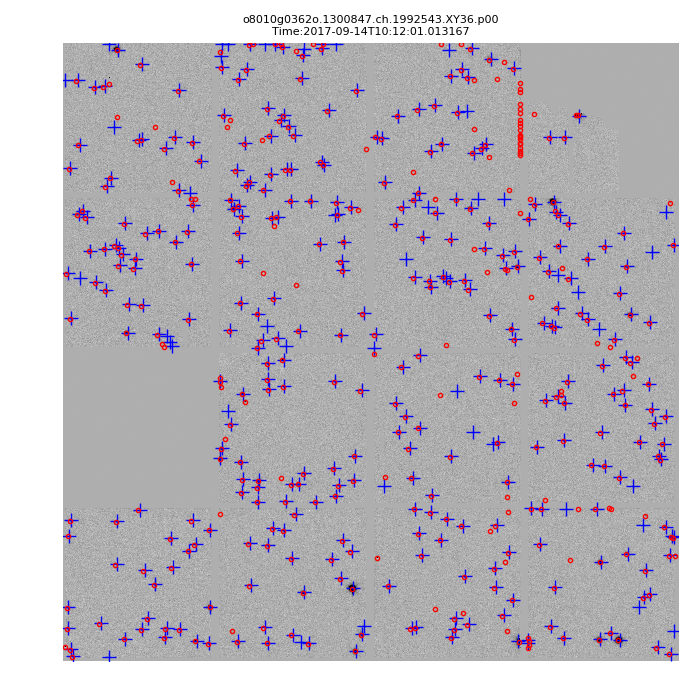

In [86]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#SHOW THE SOURCES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Which image do you want the sources be shown?
iimg=1
image=images[iimg]

fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs
imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
ax.imshow(image["data"],**imgargs)       
ax.axis("off")
itime=image["header"]["DATE-OBS"]
ax.set_title(image["file"]+"\n"+"Time:"+itime,fontsize=8,position=(0.5,1.0))

#Show the sources
ax.plot(images[0]["xy"][:,0]-1,images[0]["xy"][:,1]-1,'b+',ms=10,mfc='None')
ax.plot(image["xy"][:,0]-1,image["xy"][:,1]-1,'ro',ms=3,mfc='None')

fig.tight_layout()
fig.savefig(OUT_DIR+"sources-%d.png"%iimg)

**NOTES ON IMAGE**: Red circles show the sources in the selected images. Blue crosses are the sources detected in the first image. You may notice that there are sources in one image that were not detected in the other one.  Additionally if you make a zoom in in any area of the images you will see that the sources positions among images differ by a few pixels.  These are errors in the pointing of the telescope.

---

## Step 5: Align the sources

Before looking for moving objects we should be sure that the sources as properly aligned

In [110]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#FIND ALIGNMENT PARAMETERS
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Finding alignment transformation")
print("\tReference image:",images[0]["file"])

#Reference image is not aligned
allsources.loc[allsources.IMG==0,"X_ALIGN"]=allsources[allsources.IMG==0]["X_IMAGE"]
allsources.loc[allsources.IMG==0,"Y_ALIGN"]=allsources[allsources.IMG==0]["Y_IMAGE"]

columns=["X_IMAGE","Y_IMAGE"]
for i,image in enumerate(images[1:]):
    print("\tAligning image:",images[i]["file"])
    imsources=allsources[allsources.IMG==(i+1)]
    
    #Measure initial misalignment
    ta,sa=matchSources(imsources[columns],
                       allsources[allsources.IMG==i][columns])
    mab=np.abs(sa-ta).mean()
    print("\t\tAverage distance before alignment:",mab)

    #Align
    tr,(ta,sa)=forceAlignment(allsources,i+1,i)
    image["transform"]=tr

    #Measure misalignment after procedure
    sp=[]
    for j in range(ta.shape[0]):sp+=tr(ta[j,:]).tolist()
    sp=np.array(sp)
    maa=np.abs(sa-sp).mean()
    print("\t\tAverage distance after alignment:",maa)
    print("\t\tYou improved the alignment by a factor of ",mab/maa)
    
    #Align all coordinates
    xy=imsources[columns].values
    xya=[]
    for j in range(xy.shape[0]):
        xyr=xy[j,:]
        for ia in range(i+1,0,-1):
            tr=images[ia]["transform"]
            xyr=tr(xyr).tolist()
        xya+=xyr
    xya=np.array(xya)
    imsources[["X_ALIGN","Y_ALIGN"]]=pd.DataFrame(xya,columns=["X_ALIGN","Y_ALIGN"],index=imsources.index)
    allsources.loc[allsources.IMG==(i+1),["X_ALIGN","Y_ALIGN"]]=imsources
    
    #Measure alignment
    print("\t\tChecking alignment in the whole image:")

    ta,sa=matchSources(allsources[allsources.IMG==(i+1)],allsources[allsources.IMG==0])
    print("\t\t\tAverage distance before alignment:",np.abs(sa-ta).mean())

    ta,sa=matchSources(pd.DataFrame(allsources.loc[allsources.IMG==(i+1),["X_ALIGN","Y_ALIGN"]].values,columns=columns),
                       pd.DataFrame(allsources.loc[allsources.IMG==0,["X_ALIGN","Y_ALIGN"]].values,columns=columns))
    print("\t\t\tAverage distance after alignment:",np.abs(sa-ta).mean())

print("Done.")

Finding alignment transformation
	Reference image: o8010g0344o.1300829.ch.1992525.XY36.p00
	Aligning image: o8010g0344o.1300829.ch.1992525.XY36.p00
		Average distance before alignment: 3.80727
		Average distance after alignment: 0.394479756828
		You improved the alignment by a factor of  9.65136929267
		Checking alignment in the whole image:
			Average distance before alignment: 3.80727
			Average distance after alignment: 0.662942187772
	Aligning image: o8010g0362o.1300847.ch.1992543.XY36.p00
		Average distance before alignment: 3.08146
		Average distance after alignment: 0.137068424097
		You improved the alignment by a factor of  22.4811614839
		Checking alignment in the whole image:
			Average distance before alignment: 6.41255
			Average distance after alignment: 0.767658685615
	Aligning image: o8010g0380o.1300865.ch.1992561.XY36.p00
		Average distance before alignment: 3.09088
		Average distance after alignment: 0.435324019449
		You improved the alignment by a factor of  7.1001746

<IPython.core.display.Javascript object>


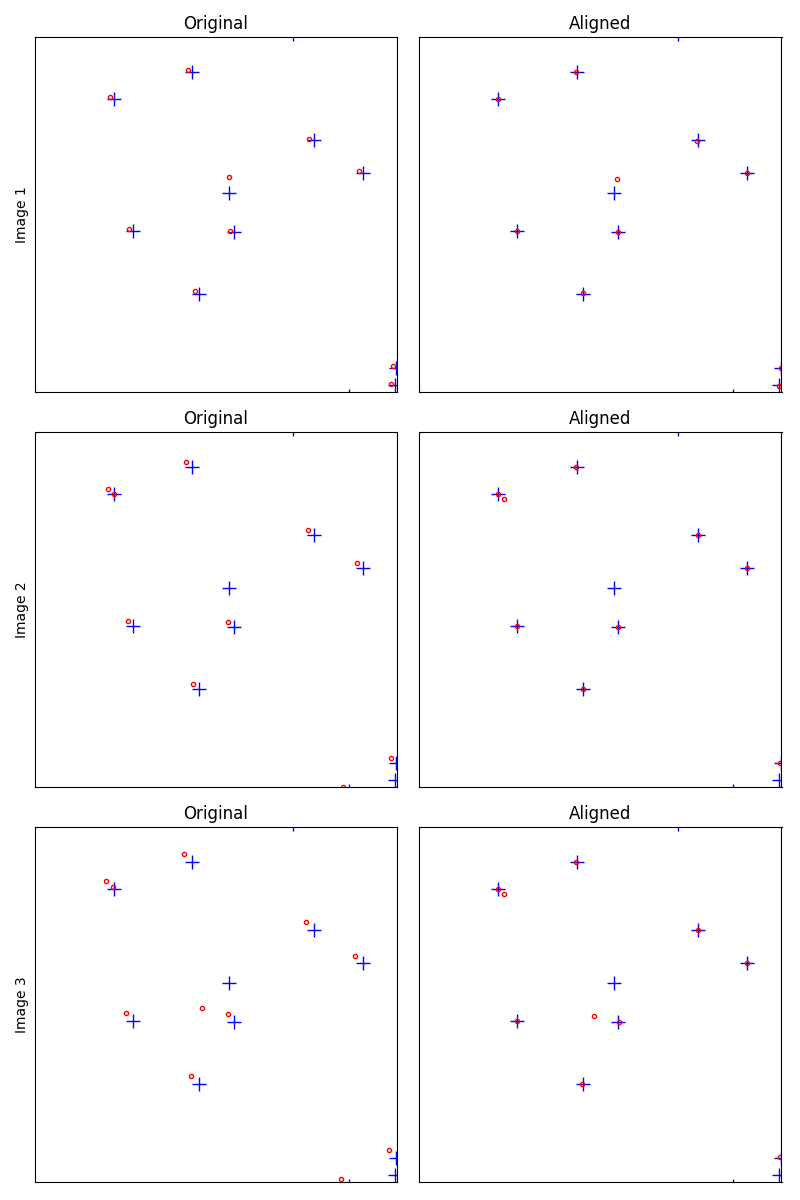

In [111]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#RESULT OF THE ALIGNMENT PROCEDURE
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
# Figure
fig,axs=plt.subplots(3,2,sharex=True,sharey=True,figsize=(8,12))

dx=SIZEX/10
dy=SIZEY/10

#Show the misaligned sources
images[0]["xy_aligned"]=allsources.loc[allsources.IMG==0,["X_ALIGN","Y_ALIGN"]].values
for i,image in enumerate(images[1:]):
    iimg=i+1
    imsource=allsources[allsources.IMG==(i+1)]
    image["xy"]=imsource[["X_IMAGE","Y_IMAGE"]].values
    image["xy_aligned"]=imsource[["X_ALIGN","Y_ALIGN"]].values
    
    xcen=image["xy"][:,0].mean()
    ycen=image["xy"][:,1].mean()
    
    ax=axs[i,0]
    ax.plot(images[0]["xy"][:,0]-1,images[0]["xy"][:,1]-1,'b+',ms=10,mfc='None')
    ax.plot(image["xy"][:,0]-1,image["xy"][:,1]-1,'ro',ms=3,mfc='None')

    ax.set_title("Original")
    ax.set_ylabel("Image %d"%iimg)

    ax=axs[i,1]
    ax.set_title("Aligned")
    ax.plot(images[0]["xy_aligned"][:,0]-1,images[0]["xy_aligned"][:,1]-1,'b+',ms=10,mfc='None')
    ax.plot(image["xy_aligned"][:,0]-1,image["xy_aligned"][:,1]-1,'ro',ms=3,mfc='None')
    
#Zoom in the center
ax.set_xlim((xcen-dx,xcen+dx))
ax.set_ylim((ycen-dy,ycen+dy))

for ax in mat2lst(axs):
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig(OUT_DIR+"alignment-%d.png"%iimg)

**NOTES ON IMAGE**: Red circles show the sources in the corresponding images, blue crosses are the sources detected in the first image.

---

## Step 6: Perform the Astrometry

In this step we identify the stars present in the field

In [89]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#BUILD DATABASE OF CLOSE SOURCES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Looking for star in the field covered by the images...")
rmin=allsources["ALPHA_J2000"].min()
rmax=allsources["ALPHA_J2000"].max()
dmin=allsources["DELTA_J2000"].min()
dmax=allsources["DELTA_J2000"].max()
rmean=(rmin+rmax)/2;dr=(rmax-rmin)/2
dmean=(dmin+dmax)/2;dd=(dmax-dmin)/2
ra=dec2sex(rmean/15)
dec=dec2sex(dmean)
ras="%d %d %.2f"%(int(ra[0]),int(ra[1]),ra[2])
des="%d %d %.2f"%(int(dec[0]),int(dec[1]),dec[2])
radius=np.sqrt(dr**2+dd**2)

columns=['_RAJ2000','_DEJ2000','R1mag']
v=Vizier(columns=columns)
v.ROW_LIMIT=-1
#radius=Angle(radius,"deg"),
result=v.query_region("%s %s"%(ras,des),
                      width=Angle(2*dr,"deg"),height=Angle(2*dd,"deg"),
                      catalog='USNOB1')[0]
cond=result["R1mag"]>0
stars=pd.DataFrame(rec2arr(result[cond]),
                   columns=["ALPHA_J2000","DELTA_J2000","Rmag"])
print("\tNumber of reference stars found:",len(stars))

Looking for star in the field covered by the images...
	Number of reference stars found: 108


<IPython.core.display.Javascript object>


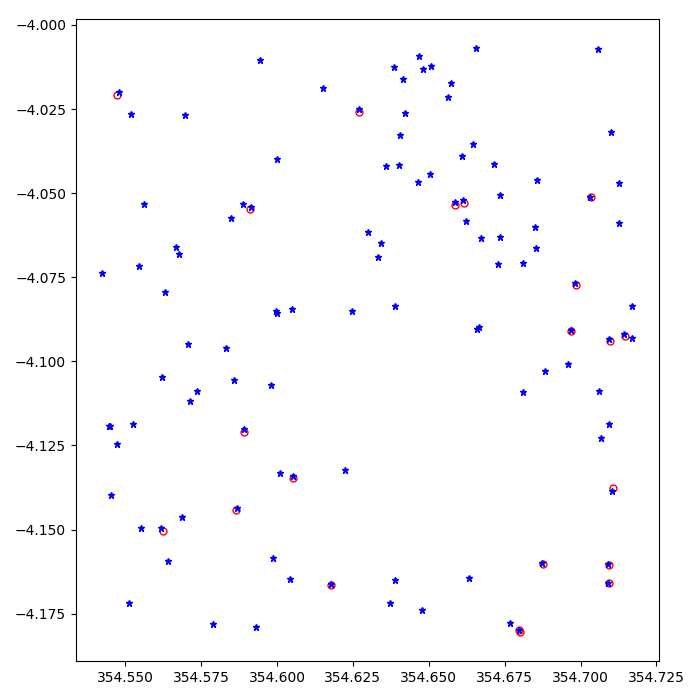

In [93]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#SHOW THE STARS IN THE FIELD
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
iimg=0
imgsources=allsources[allsources.IMG==iimg][allsources.MAG_BEST<-12]
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs

#Show the sources
ax.plot(imgsources["ALPHA_J2000"],imgsources["DELTA_J2000"],'ro',ms=5,mfc='None')
ax.plot(stars["ALPHA_J2000"],stars["DELTA_J2000"],'b*',ms=5)

fig.tight_layout()
fig.savefig(OUT_DIR+"stars.png")

In [123]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#MATCH IMAGE AND STAR DATABASE
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Matching stars...")
a="ALPHA_J2000"
d="DELTA_J2000"

for i,image in enumerate(images):
    file=image["file"]
    imgsources=allsources[allsources.IMG==i]
    bright=imgsources[imgsources.MAG_BEST<-14]
    nbright=len(bright)

    #Comparing set of sources
    print("\tMatching for image %s"%file)    
    print("\t\tNumber of selected bright stars:",len(bright))
    print("\t\tPresent average distance to stars:",distanceSets([0,0],bright,stars,a,d)/nbright/ARCSEC)
        
    #Find optimal translation
    solution=minimize(distanceSets,[0,0],method='Nelder-Mead',tol=1e-6,args=(bright,stars,a,d))
    image["translation"]=solution.x

    print("\t\tMatching parameters:",image["translation"])
    print("\t\tImproved average distance:",distanceSets(image["translation"],bright,stars,a,d)/nbright/ARCSEC)
    
    #Translate position of stars
    bright[[a,d]]=[translation2D(image["translation"],[alpha,delta])\
                                 for alpha,delta in zip(bright[a],bright[d])]

    #Match bright sources and stars
    stars_ind=matchSets(bright,stars,a,d)
    zeros=stars.loc[stars_ind,"Rmag"].values-bright["MAG_BEST"].values
    image["zeropoint"]=zeros.mean()
    image["zerostd"]=zeros.std()
    
    #Aligning positions
    print("\t\tAligning")    
    tr=SimilarityTransform()
    status=tr.estimate(bright[[a,d]].values,stars.loc[stars_ind,[a,d]].values)
    print("\t\t\tSuccess:",status)
    image["astrometry"]=tr
    
    #Alligning all sources
    xy=imgsources[[a,d]].values
    xya=[]
    for j in range(xy.shape[0]):
        xyr=xy[j,:]
        xyr=translation2D(image["translation"],xyr)
        xyr=image["astrometry"](xyr).tolist()
        xya+=xyr
    xya=np.array(xya)
    
    imgsources[["RA","DEC"]]=pd.DataFrame(xya,columns=["RA","DEC"],index=imgsources.index)
    allsources.loc[allsources.IMG==i,["RA","DEC"]]=imgsources
    
    #Photometric properties
    allsources.loc[allsources.IMG==i,["MAG_ASTRO"]]=imgsources["MAG_BEST"]+image["zeropoint"]
    allsources.loc[allsources.IMG==i,["ERR_MAG_ASTRO"]]=(imgsources["MAGERR_BEST"]**2+image["zerostd"]**2).apply(np.sqrt)
    
    #Last verification
    imgsources=allsources[allsources.IMG==i]
    bright=imgsources[imgsources.MAG_BEST<-14]
    nstars=stars.rename(columns={"ALPHA_J2000":"RA","DELTA_J2000":"DEC"})
    print("\t\tAverage distance to stars after astrometry:",distanceSets([0,0],bright,nstars,"RA","DEC")/nbright/ARCSEC)

Matching stars...
	Matching for image o8010g0344o.1300829.ch.1992525.XY36.p00
		Number of selected bright stars: 4
		Present average distance to stars: 2.50202995472
		Matching parameters: [ -5.19410315e-04  -1.49677396e+00]
		Improved average distance: 1.48793420674
		Aligning
			Success: True
		Average distance to stars after astrometry: 0.985755664268
	Matching for image o8010g0362o.1300847.ch.1992543.XY36.p00
		Number of selected bright stars: 6
		Present average distance to stars: 2.36240543777
		Matching parameters: [ -5.32126354e-04  -1.07400535e+00]
		Improved average distance: 1.63289216942
		Aligning
			Success: True
		Average distance to stars after astrometry: 1.46437434477
	Matching for image o8010g0380o.1300865.ch.1992561.XY36.p00
		Number of selected bright stars: 8
		Present average distance to stars: 2.32015131053
		Matching parameters: [ -4.95556375e-04  -1.41784672e+00]
		Improved average distance: 1.54358564989
		Aligning
			Success: True
		Average distance to stars

<IPython.core.display.Javascript object>


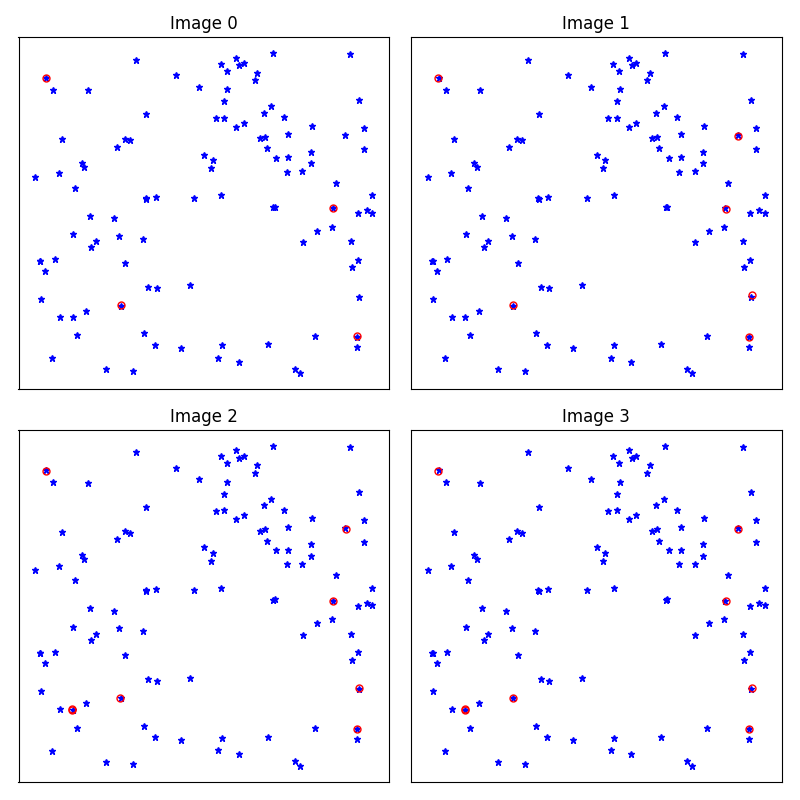

In [95]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#PLOT IMAGE MATCH
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
npx=int(len(images)/2)

fig,axs=plt.subplots(npx,2,sharex=True,sharey=True,figsize=(2*4,4*npx))
axl=mat2lst(axs)

for i,image in enumerate(images):

    imgsources=allsources[allsources.IMG==i]
    bright=imgsources[imgsources.MAG_BEST<-14]
    
    #Show the sources
    axl[i].plot(stars.loc[stars.index[:]]["ALPHA_J2000"],stars.loc[stars.index[:]]["DELTA_J2000"],'b*',ms=5)
    axl[i].plot(bright.loc[bright.index[:]]["RA"],bright.loc[bright.index[:]]["DEC"],'ro',ms=5,mfc='None')
    
    axl[i].set_title("Image %d"%i)
    axl[i].set_xticks([])
    axl[i].set_yticks([]) 
    #break
    
fig.tight_layout()
fig.savefig(OUT_DIR+"stars-%d.png"%i)

---

## Step 6: Detect potential moving objects

At this step we will check which of the sources appear on just one image.  They are the potential moving objects.

In [124]:
#############################################################
#1-FIND POTENTIAL MOVING OBJECTS
#############################################################
print("Find potential moving objects...")
print("\tSearching RADIUS (pixels, arcsec):",CONF.RADIUS,CONF.RADIUS*PXSIZE/ARCSEC)
RADIUS=CONF.RADIUS

iobj=1
for i,ind in enumerate(allsources.index):
    obj=allsources.loc[ind]
    x=obj.X_ALIGN;y=obj.Y_ALIGN
    if obj.NIMG>1:continue

    #COMPUTE THE EUCLIDEAN DISTANCE TO ALL OBJECTS NOT FOUND YET
    cond=allsources.NIMG==1
    searchobjs=allsources[cond]
    ds=((x-searchobjs.X_ALIGN)**2+(y-searchobjs.Y_ALIGN)**2).apply(np.sqrt)

    #IN HOW MANY IMAGES THE OBJECT IS PRESENT
    cond=ds<RADIUS
    inds=searchobjs[cond].index
    nimg=len(allsources.ix[inds])
    allsources.loc[inds,"NIMG"]=nimg

    #ASSIGN OBJECT NUMBER
    if nimg==4:
        allsources.loc[inds,"OBJ"]=iobj
        iobj+=1

moving=allsources[allsources.NIMG<2]
rest=allsources[allsources.NIMG>=2]
print("\tNumber of potentially moving objects: ",len(moving))

Find potential moving objects...
	Searching RADIUS (pixels, arcsec): 3 0.766783666346
	Number of potentially moving objects:  253


<IPython.core.display.Javascript object>


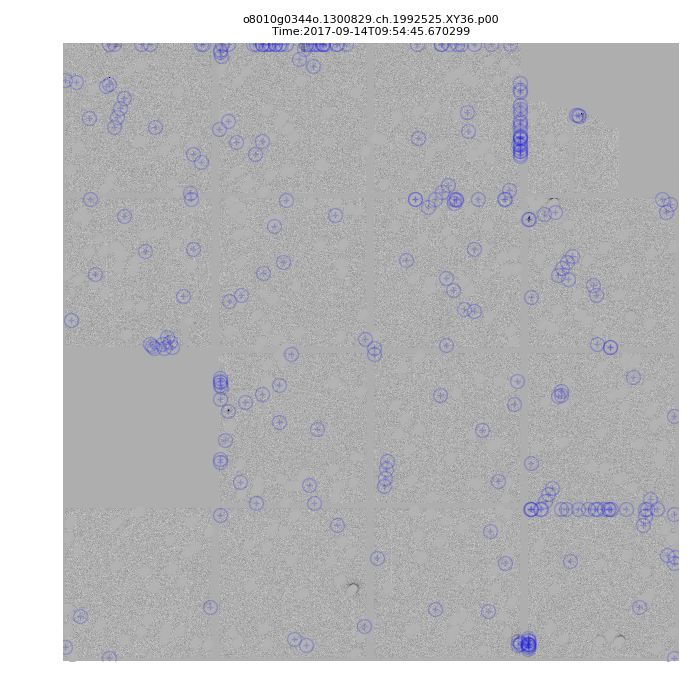

In [97]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#SHOW THE PTENTIAL MOVING OBJECTS
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Which image do you want the sources be shown?
iimg=0
image=images[iimg]

fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs
imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
ax.imshow(image["data"],**imgargs)       
ax.axis("off")
time=image["header"]["DATE-OBS"]
ax.set_title(image["file"]+"\n"+"Time:"+time,fontsize=8,position=(0.5,1.0))

#Show the sources
gray=plt.get_cmap('gray')
ax.plot(rest["X_IMAGE"]-1,rest["Y_IMAGE"],'o',color=gray(0.7),ms=5,alpha=1)
ax.plot(rest["X_IMAGE"]-1,rest["Y_IMAGE"],'o',color=gray(0.7),ms=5,alpha=1)
ax.plot(moving["X_IMAGE"]-1,moving["Y_IMAGE"],'bo',ms=10,mfc='None',alpha=0.2)
ax.plot(moving["X_IMAGE"]-1,moving["Y_IMAGE"],'b+',ms=5,mfc='None',alpha=0.2)

fig.tight_layout()
fig.savefig(OUT_DIR+"moving.png")

**NOTES**: Objects in rest have been masked (gray circles) to highlight the moving objects which are in the center of the blue circles.

---

## Step 7: Detect the asteroids

In [125]:
#############################################################
#DETECT ASTEROIDS
#############################################################
print("Find moving objects...")
layers=[]
for i in range(len(images)):
    layers+=[moving[moving.IMG==i].sort_values(by=['X_ALIGN','Y_ALIGN'])]

#Ranges
xmax=max(allsources.X_ALIGN);xmin=min(allsources.X_ALIGN)
ymax=max(allsources.Y_ALIGN);ymin=min(allsources.Y_ALIGN)

#First level of crossing
dt1=(images[1]["unixtime"]-images[0]["unixtime"])
dt2=(images[2]["unixtime"]-images[1]["unixtime"])
dt3=(images[3]["unixtime"]-images[1]["unixtime"])

nobj=0
indxs=[]
mobj=1
for indl in layers[0].index:
    objl=layers[0].loc[indl]

    nout=0;nfar=0;nfou=0;ntot=0
    for indu in layers[1].index:
        ntot+=1
        obju=layers[1].loc[indu]

        #Compute speed
        vr=(obju.X_ALIGN-objl.X_ALIGN)/dt1
        vd=(obju.Y_ALIGN-objl.Y_ALIGN)/dt1

        #Check distance to close object
        d=np.sqrt((vr*dt1)**2+(vd*dt1)**2)
        if d<2*RADIUS:
            #If close object is too close continue
            continue

        #Extrapolate to next layer (Layer 2)
        xn=obju.X_ALIGN+vr*dt2
        yn=obju.Y_ALIGN+vd*dt2

        #Check if extrapolated position is beyond searching region
        if xn>xmax or xn<xmin or yn>ymax or yn<ymin:
            nout+=1
            continue

        #Search for close objects in the next layer (Layer 2)
        cond=((layers[2].Y_ALIGN-yn)**2+
              (layers[2].X_ALIGN-xn)**2).apply(np.sqrt).sort_values()<RADIUS
        exts=layers[2][cond]
        if len(exts)==0:
            #No close objects in the following layer
            nfar+=1
            continue

        dmin=((exts.Y_ALIGN-yn)**2+(exts.X_ALIGN-xn)**2).apply(np.sqrt).iat[0]
        idmin1=exts.index[0]

        #Extrapolate to next layer (Layer 3)
        xu=obju.X_ALIGN+vr*dt3
        yu=obju.Y_ALIGN+vd*dt3

        #Check if extrapolated position is beyond searching region
        if xu>xmax or xu<xmin or yu>ymax or yu<ymin:
            nout+=1
            continue

        #Search for close objects in the next layer (Layer 3)
        cond=((layers[3].Y_ALIGN-yu)**2+
              (layers[3].X_ALIGN-xu)**2).apply(np.sqrt).sort_values()<RADIUS
        exts=layers[3][cond]
        if len(exts)==0:
            nfar+=1
            continue

        dmin=((exts.Y_ALIGN-yu)**2+(exts.X_ALIGN-xu)**2).apply(np.sqrt).iat[0]
        idmin2=exts.index[0]

        if dmin<RADIUS:
            nfou+=1
            nobj+=1
            nindx=[indl,indu,idmin1,idmin2]
            indxs+=nindx
            allsources.loc[nindx,"MOBJ"]=mobj
            mobj+=1

print("\t%d objects found"%nobj)

Find moving objects...
	5 objects found


	Annotated ('scratch/ps1-20170914_4_set096//detection-ps1-20170914_4_set096.gif')


<IPython.core.display.Javascript object>


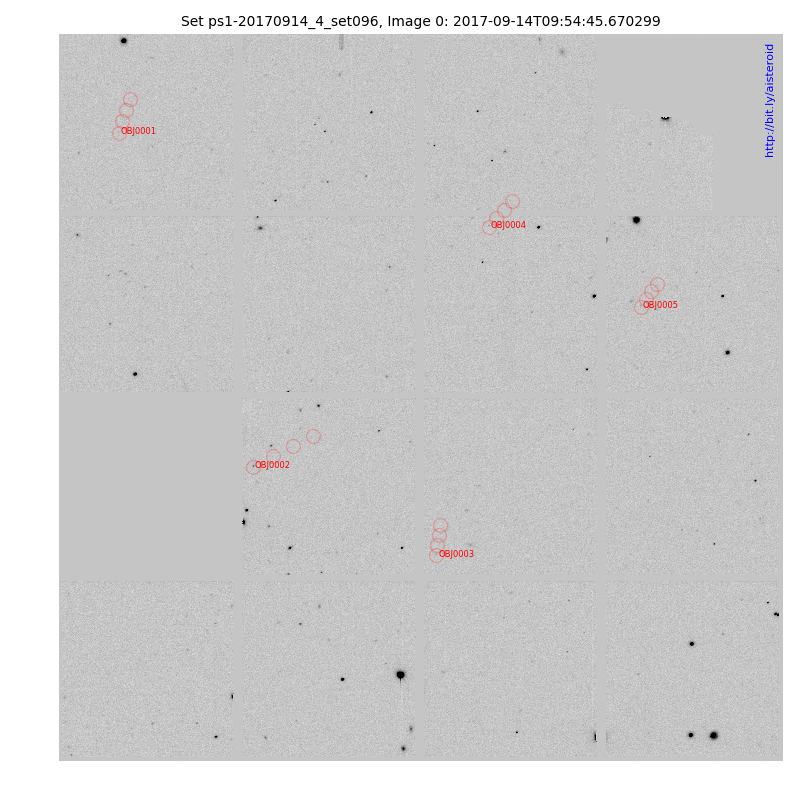

	Done.


In [99]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#ANNOTATED
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
import time
animfile="%s/detection-%s.gif"%(OUT_DIR,CONF.SET)
print("\tAnnotated ('%s')"%animfile)

#Figure
fig=plt.figure(figsize=(8,8))

#Show first image
imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
im=plt.imshow(images[0]["data"],animated=True,**imgargs)

#Title
tm=plt.title("Set %s, Image 0: "%CONF.SET+images[0]["obstime"],fontsize=10)

#Water mark
waterMark(fig.gca())

#Show detected objects
for mobj in range(1,nobj+1):
    cond=allsources.loc[indxs].MOBJ==mobj
    inds=allsources.loc[indxs].index[cond]
    idobj="%s%04d"%("OBJ",mobj)
    n=1
    for ind in inds:
        obj=allsources.loc[ind]
        plt.plot(obj.X_IMAGE-1,obj.Y_IMAGE-1,'ro',ms=10,mfc='None',alpha=0.2)
        if n==1:
            plt.text(obj.X_IMAGE+5,obj.Y_IMAGE+5,"%s"%idobj,color='r',fontsize=6)
        n+=1

#Basic decoration
plt.axis("off")
fig.tight_layout()

#Update figure
def updatefig(i):
    #Select image
    iimg=i%nimgs
    im.set_array(images[iimg]["data"])
    tm.set_text("Set %s, Image %d: "%(CONF.SET,iimg)+images[iimg]["obstime"])
    return im,


#Create animation
ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                            interval=1000,repeat_delay=1000,
                            repeat=True,blit=True)

#Save animattion
out=System("rm -rf %s/blink*"%OUT_DIR)
ani.save(OUT_DIR+'blink.html')
time.sleep(1)
out=System("convert -delay 100 $(find %s -name 'blink*.png' -o -name 'frame*.png' |grep -v '04' |sort) %s"%(OUT_DIR,animfile))
out=System("rm -rf blink*")
print("\tDone.")

---

## Step 8: Photometry

Now that we have the objects we proceed to perform the photometry

In [166]:
#############################################################
#PERFORM PHOTOMETRY ON DETECTED OBJECTS
#############################################################
print("PSF fitting for objects")
columns=allsources.columns.tolist()+["IDOBJ","IDIMG","DATE"
                                     "SNR","FWHM",
                                     "X_PSF","Y_PSF",
                                     "MAG_MEAN","MAG_MIN","MAG_MAX","MAG_RANGE","MAG_VAR",
                                     "SNR_MEAN","SNR_MIN","SNR_MAX","SNR_RANGE","SNR_VAR"]
objects=pd.DataFrame(columns=columns)

for mobj in range(1,nobj+1):

    #Get sources corresponding to object mobj
    cond=allsources.loc[indxs].MOBJ==mobj
    inds=allsources.loc[indxs].index[cond]

    #Create an index for this object
    idobj="%04d"%(mobj)

    print("\tObject %s:"%idobj)
    n=1
    mags=[]
    snrs=[]
    for ind in inds:

        #Get object information
        objp=allsources.loc[ind]
        iimg=int(objp.IMG)
        image=images[iimg]
        READOUT=image["header"]["HIERARCH CELL.READNOISE"]

        idimg=idobj+"."+str(n)
        objp["IDIMG"]=idimg
        objp["IDOBJ"]=idobj

        print("\t\tPSF fitting for image of object OBJ%s"%idimg)
        n+=1

        #DATE
        obstime=images[iimg]["obstime"]
        exptime=float(images[iimg]["header"]["EXPTIME"])
        parts=obstime.split(".")
        dt=datetime.strptime(parts[0],"%Y-%m-%dT%H:%M:%S")
        fday=(dt.hour+dt.minute/60.0+(dt.second+exptime/2+int(parts[1])/1e6)/3600.0)/24.0
        fday=("%.6f"%fday).replace("0.","")
        objp["DATE"]=dt.strftime("%Y %m %d.")+fday

        #GET DATA IMAGE
        data=rec2arr(images[iimg]["data"])
        x=int(objp.X_IMAGE)
        y=int(objp.Y_IMAGE)
        print("\t\t\tExpected position:",x,y)
        
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #2D PSH FIT
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        dx=10 #Error in photometry
        dy=10 #Error in photometry
        ws=5  #Number of errors to select for fitting
        xs=np.arange(x-ws*dx,x+ws*dx,1)
        pxs=data[y,x-ws*dx:x+ws*dx,0]
        ys=np.arange(y-ws*dy,y+ws*dy,1)
        pys=data[y-ws*dy:y+ws*dy,x,0]

        sigmax2=10 #Estimated error in X
        sigmay2=10 #Estimated error in y
        meanx=x
        meany=y
        X,Y=np.meshgrid(xs,ys)
        P=data[y-ws*dy:y+ws*dy,x-ws*dx:x+ws*dx,0]

        def gaussianLevel2(tx,ty,level=0.0,amplitude=1.0,
                           meanx=meanx,meany=meany,
                           sigmax2=sigmax2,sigmay2=sigmay2):
            g=amplitude*np.exp(-0.5*((tx-meanx)**2/sigmax2+(ty-meany)**2/sigmay2))
            f=g+level
            return f

        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #FIT RESULTS
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        g_init=custom_model(gaussianLevel2)()
        fit=fitting.SLSQPLSQFitter()
        g=fit(g_init,X,Y,P,verblevel=0)
        #print("\t\tResults (level,amplitude,meanx,meany,sigmax,sigmay):\n\t\t\t%s"%str(g.parameters))

        xc=g.meanx.value
        yc=g.meany.value
        sigmam=np.sqrt(g.sigmax2.value+g.sigmay2.value)
        amplitude=g.amplitude.value
        level=g.level.value
        objp["FWHM"]=2.355*sigmam
        objp["X_PSF"]=xc
        objp["Y_PSF"]=yc

        print("\t\t\tPSF position:",xc,yc)
        print("\t\t\tFWHM:",objp.FWHM)
        
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #COMPUTE SNR
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        title="Object %d, %s, %s"%(ind,idimg,obstime)

        ws=5
        x=int(g.meanx.value)
        y=int(g.meany.value)
        dx=int(np.sqrt(g.sigmax2.value))
        dy=int(np.sqrt(g.sigmay2.value))
        xs=np.arange(x-ws*dx,x+ws*dx,1)
        ys=np.arange(y-ws*dy,y+ws*dy,1)
        X,Y=np.meshgrid(xs,ys)
        P=data[y-ws*dy:y+ws*dy,x-ws*dx:x+ws*dx,0]
        Pth=gaussianLevel2(X,Y,
                           level=g.level.value,amplitude=g.amplitude.value,
                           meanx=g.meanx.value,meany=g.meany.value,
                           sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)
        D=P-Pth
        noise=D.std()
        objp["SNR"]=g.amplitude.value/noise
        print("\t\t\tSNR = ",objp.SNR)
        print("\t\t\tMAG = %.1f +/- %.2f"%(objp.MAG_ASTRO,objp.ERR_MAG_ASTRO))
        mags+=[objp.MAG_ASTRO]
        snrs+=[objp.SNR]
        
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #PLOT 2D FIT
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        if CONF.PHOTOPLOT:
            plt.ioff()
            fig = plt.figure()
            ax3d = fig.add_subplot(111, projection='3d')
            ax3d.plot_wireframe(X,Y,P,lw=0.5)
            ngrid=50
            Xs,Ys=np.meshgrid(np.linspace(xs[0],xs[-1],ngrid),
                              np.linspace(ys[0],ys[-1],ngrid))
            Zs=gaussianLevel2(Xs,Ys,
                              level=g.level.value,amplitude=g.amplitude.value,
                              meanx=g.meanx.value,meany=g.meany.value,
                              sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)
            ax3d.plot_surface(Xs,Ys,Zs,cmap='hsv',alpha=0.2)
            ax3d.set_title(title,position=(0.5,1.05),fontsize=10)
            fig.savefig(OUT_DIR+"psf2d-%s.png"%idimg)

            #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
            #1D PLOT OF PSF FITTING
            #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
            xs=np.arange(x-ws*dx,x+ws*dx,1)
            pxs=data[y,x-ws*dx:x+ws*dx,0]
            pxts=level+amplitude*np.exp(-0.5*((xs-x)**2/g.sigmax2.value))
            rxs=pxs-pxts

            ys=np.arange(y-ws*dy,y+ws*dy,1)
            pys=data[y-ws*dy:y+ws*dy,x,0]
            pyts=level+amplitude*np.exp(-0.5*((ys-y)**2/g.sigmay2.value))
            rys=pys-pyts

            xt=np.linspace(xs[0],xs[-1],100)
            pt=level+amplitude*np.exp(-0.5*((xt-x)**2/g.sigmax2.value))

            fig,axs=plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[2,1]})
            ax=axs[0]
            ax.plot((xs-x)/np.sqrt(g.sigmax2.value),pxs,'ko')
            ax.plot((ys-y)/np.sqrt(g.sigmay2.value),pys,'ko')
            ax.plot((xt-x)/np.sqrt(g.sigmax2.value),pt,'r-')
            ax.set_xlim((-ws,+ws))
            ax.set_ylim((min(pxs.min(),pys.min()),max(pxs.max(),pys.max())))
            ax.axvspan(-objp.FWHM/2/sigmam,+objp.FWHM/2/sigmam,color='b',alpha=0.2)
            ax.axhspan(0,level,color='k',alpha=0.2)
            ax.set_xticks([])
            legend=""
            legend+="SNR = %.2f\n"%objp.SNR
            legend+="FWHM (arcsec) = %.2f\n"%(objp.FWHM*PXSIZE/ARCSEC)
            legend+="MAG = %+.1f\n"%(objp.MAG_ASTRO)
            ax.text(0.95,0.95,legend,
                    ha='right',va='top',transform=ax.transAxes,color='k',fontsize=12)
            ax.set_ylabel("Counts")
            ax.set_title("Object %s"%idimg)
            waterMark(ax)

            ax=axs[1]
            ax.plot((xs-x)/np.sqrt(g.sigmax2.value),rxs,'ko')
            ax.plot((ys-y)/np.sqrt(g.sigmay2.value),rys,'ko')
            ax.set_ylim((-level,level))
            ax.axhspan(-noise,noise,color='k',alpha=0.2)
            ax.set_ylabel("Residual (count)")

            fig.tight_layout()
            fig.subplots_adjust(hspace=0)
            fig.savefig(OUT_DIR+"psf1d-%s.png"%idimg)

        #ADD OBJECT
        objects=objects.append(objp,ignore_index=True)

        #break
    mags=np.array(mags)
    snrs=np.array(snrs)
    
    #Storing object properties
    objects.loc[objects.IDOBJ==idobj,"MAG_MIN"]=mags.min()
    objects.loc[objects.IDOBJ==idobj,"MAG_MAX"]=mags.max()
    objects.loc[objects.IDOBJ==idobj,"MAG_RANGE"]=mags.max()-mags.min()
    objects.loc[objects.IDOBJ==idobj,"MAG_MEAN"]=mags.mean()
    objects.loc[objects.IDOBJ==idobj,"MAG_VAR"]=mags.std()

    objects.loc[objects.IDOBJ==idobj,"SNR_MIN"]=snrs.min()
    objects.loc[objects.IDOBJ==idobj,"SNR_MAX"]=snrs.max()
    objects.loc[objects.IDOBJ==idobj,"SNR_RANGE"]=snrs.max()-snrs.min()
    objects.loc[objects.IDOBJ==idobj,"SNR_MEAN"]=snrs.mean()
    objects.loc[objects.IDOBJ==idobj,"SNR_VAR"]=snrs.std()

    print("\t\tMag: [%.1f,%.1f:%.1f] %.1f +/- %.2f"%(mags.min(),mags.max(),
                                                     mags.max()-mags.min(),
                                                     mags.mean(),mags.std()))
    print("\t\tSNR: [%.1f,%.1f:%.1f] %.1f +/- %.2f"%(snrs.min(),snrs.max(),
                                                     snrs.max()-snrs.min(),
                                                     snrs.mean(),snrs.std()))

objects.to_csv(OUT_DIR+"objects-%s.csv"%CONF.SET,index=False)

PSF fitting for objects
	Object 0001:
		PSF fitting for image of object OBJ0001.1
			Expected position: 200 329
			PSF position: 199.509020631 328.95486186
			FWHM: 6.271549828998362
			SNR =  3.6017898184134185
			MAG = 21.8 +/- 0.22
		PSF fitting for image of object OBJ0001.2
			Expected position: 211 290
			PSF position: 211.485235384 289.765408638
			FWHM: 8.148444368241325
			SNR =  2.568740436915734
			MAG = 21.4 +/- 0.92
		PSF fitting for image of object OBJ0001.3
			Expected position: 226 254
			PSF position: 225.682751693 253.170299734
			FWHM: 5.33542282646964
			SNR =  5.194019277445962
			MAG = 21.2 +/- 0.92
		PSF fitting for image of object OBJ0001.4
			Expected position: 240 216
			PSF position: 239.639948865 215.674351446
			FWHM: 5.395854868230194
			SNR =  4.032839769493516
			MAG = 21.1 +/- 0.72
		Mag: [21.1,21.8:0.7] 21.4 +/- 0.26
		SNR: [2.6,5.2:2.6] 3.8 +/- 0.94
	Object 0002:
		PSF fitting for image of object OBJ0002.1
			Expected position: 651 1448
			PSF position

---

## Step 8: Select objects

Here we present the information about the found moving objects.

In [231]:
selfile=OUT_DIR+"select-%s.txt"%CONF.SET
f=open(selfile,"w")
print("Generating selection report...")

typo="C"
mago="R"
lines=""
header="%-5s|%-68s|%-10s|%-10s|%-10s|\n"%("ID","REPORT","SNR_MIN","SNR_MAX","MAG_RANGE")
f.write(header)
f.write("-"*len(header)+"\n")
for ind in objects.index:
    objp=objects.loc[ind]
    parts=str(objp.IDIMG).split(".")
    idimg="%04d.%1d"%(int(parts[0]),int(parts[1]))
    idobj="%s%s"%(CONF.TEAM,objp.IDOBJ)
    print("\tReport for image %s"%idimg)
    
    mag=objp.MAG_ASTRO
    ras=dec2sex(objp.RA/15)
    decs=dec2sex(objp.DEC)
    
    entry="%3s%1s%02d %02d %6.3f%02d %02d %5.2f%13.1f%2s%9s"%\
        (typo,
         objp.DATE,
         int(ras[0]),int(ras[1]),ras[2],
         int(decs[0]),int(decs[1]),decs[2],
         mag,
         mago,
         MPCCODE
        )

    line="%-5s|%-68s|%-10.2f|%-10.2f|%-10.2f|\n"%\
        (objp.IDOBJ,
         entry,
         objp.SNR_MIN,
         objp.SNR_MAX,
         objp.MAG_RANGE
        )
    lines+=line

if len(objects.index)==0:
    f.write("NO MOVING OBJECTS DETECTED\n\n")
else:
    f.write(lines)
f.close()

Generating selection report...
	Report for image 0001.1
	Report for image 0001.2
	Report for image 0001.3
	Report for image 0001.4
	Report for image 0002.1
	Report for image 0002.2
	Report for image 0002.3
	Report for image 0002.4
	Report for image 0003.1
	Report for image 0003.2
	Report for image 0003.3
	Report for image 0003.4
	Report for image 0004.1
	Report for image 0004.2
	Report for image 0004.3
	Report for image 0004.4
	Report for image 0005.1
	Report for image 0005.2
	Report for image 0005.3
	Report for image 0005.4


In [233]:
out=System("cat "+selfile)
Image(url=OUT_DIR+"detection-%s.gif"%CONF.SET)

ID   |REPORT                                                              |SNR_MIN   |SNR_MAX   |MAG_RANGE |
-------------------------------------------------------------------------------------------------------------
0001 |  C2017 09 14.41328923 38 16.700-4 01 10.85         21.8 R      F51 |2.57      |5.19      |0.70      |
0001 |  C2017 09 14.42527223 38 15.955-4 01 14.82         21.4 R      F51 |2.57      |5.19      |0.70      |
0001 |  C2017 09 14.43721423 38 15.242-4 01 19.42         21.2 R      F51 |2.57      |5.19      |0.70      |
0001 |  C2017 09 14.44913123 38 14.524-4 01 23.44         21.1 R      F51 |2.57      |5.19      |0.70      |
0002 |  C2017 09 14.41328923 38 35.602-4 03 15.24         19.9 R      F51 |16.29     |19.10     |0.57      |
0002 |  C2017 09 14.42527223 38 34.900-4 03 33.34         19.5 R      F51 |16.29     |19.10     |0.57      |
0002 |  C2017 09 14.43721423 38 34.221-4 03 51.25         19.4 R      F51 |16.29     |19.10     |0.57      |
0002 |  C2017 09 1

In [238]:
#Now select which objects you want to remove from report
remove=[]

---

## Step 9: Finally the report!

In [239]:
fs=open(selfile,"r")

repfile=OUT_DIR+"report-%s.txt"%CONF.SET
fr=open(repfile,"w")

#Time of report                                                                                                                                                                      
NOW=datetime.now()
NOW=NOW.strftime("%Y.%m.%d %H:%M:%S")

fr.write("""COD %s
OBS %s
MEA %s (%s, %s)
TEL %s
ACK MPCReport file updated %s
NET PPMXL

Image set: %s

"""%(MPCCODE,OBSERVER,
     CONF.TEAM_MEMBERS,CONF.TEAM,CONF.TEAM_COUNTRY,
     TELESCOPE,NOW,CONF.SET))

print("Generating report %s..."%repfile)

i=0
n=1
iold=0
for line in fs.readlines():
    i+=1
    if i<=2:continue
    parts=line.strip().split("|")
    idobj=parts[0].strip()
    if idobj in remove:continue
    if iold>0 and int(idobj)!=iold:
        n+=1
    nobj="%s%04d"%(CONF.TEAM,n)
    print("\tSaving object %s (old %s)..."%(nobj,idobj))
    line="%12s%s"%(nobj,parts[1])
    fr.write("%s\n"%line)
    iold=int(idobj)
    
if len(objects.index)==0:
    fr.write("NO MOVING OBJECTS DETECTED\n\n")

fr.write("----- end -----\n")
fr.close()

Generating report scratch/ps1-20170914_4_set096/report-ps1-20170914_4_set096.txt...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0003 (old 0003)...
	Saving object NEA0003 (old 0003)...
	Saving object NEA0003 (old 0003)...
	Saving object NEA0003 (old 0003)...
	Saving object NEA0004 (old 0004)...
	Saving object NEA0004 (old 0004)...
	Saving object NEA0004 (old 0004)...
	Saving object NEA0004 (old 0004)...
	Saving object NEA0005 (old 0005)...
	Saving object NEA0005 (old 0005)...
	Saving object NEA0005 (old 0005)...
	Saving object NEA0005 (old 0005)...


In [245]:
out=System("cat -n "+repfile)

     1	COD F51
     2	OBS N. Primak, A. Schultz, S. Watters, J. Thiel, T. Goggia
     3	MEA J.Ospina, L. Piedraita, I.Moreno, S.Lopez, J. Zuluaga (NEA, Colombia)
     4	TEL 1.8-m f/4.4 Ritchey-Chretien + CCD
     5	ACK MPCReport file updated 2018.01.07 12:48:33
     6	NET PPMXL
     7
     8	Image set: ps1-20170914_4_set096
     9
    10	     NEA0001  C2017 09 14.41328923 38 16.700-4 01 10.85         21.8 R      F51
    11	     NEA0001  C2017 09 14.42527223 38 15.955-4 01 14.82         21.4 R      F51
    12	     NEA0001  C2017 09 14.43721423 38 15.242-4 01 19.42         21.2 R      F51
    13	     NEA0001  C2017 09 14.44913123 38 14.524-4 01 23.44         21.1 R      F51
    14	     NEA0002  C2017 09 14.41328923 38 35.602-4 03 15.24         19.9 R      F51
    15	     NEA0002  C2017 09 14.42527223 38 34.900-4 03 33.34         19.5 R      F51
    16	     NEA0002  C2017 09 14.43721423 38 34.221-4 03 51.25         19.4 R      F51
    17	     NEA0002  C2017 09 14.44913123 38 33.534-4 04  